In [ ]:
!nvidia-smi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/yolo_training_alper"
os.makedirs(PROJECT_ROOT, exist_ok=True)

print("Saving everything to:", PROJECT_ROOT)


In [ ]:
from IPython.display import Image

In [ ]:
import zipfile, os, shutil

LOCAL_REPO_DIR = "/content/YOLOv8-DeepSORT-Object-Tracking"

# Clean old leftovers in case you rerun the notebook
if os.path.exists(LOCAL_REPO_DIR):
    shutil.rmtree(LOCAL_REPO_DIR)

with zipfile.ZipFile('/content/drive/MyDrive/YOLOv8-DeepSORT-Object-Tracking.zip', 'r') as zipObj:
    zipObj.extractall('/content')

print("Project extracted to:", LOCAL_REPO_DIR)


In [ ]:
# 5. Go to the project root first
%cd /content/YOLOv8-DeepSORT-Object-Tracking

# 5a. Install the repo in editable mode (if it actually has setup/pyproject)
!pip install -e .

# 5b. Force a stable ultralytics version we like
!pip uninstall -y ultralytics -q
!pip install -q "ultralytics>=8.2,<9.0"

# 5c. Sanity check
import torch, ultralytics
print("Torch:", torch.__version__)
print("Ultralytics:", ultralytics.__version__)


In [ ]:
# Cell 7: Download Deep SORT code and make it importable

import os, shutil, sys

# 1. Download deep_sort_pytorch.zip into /content if it's not already there
%cd /content
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t" -O deep_sort_pytorch.zip

# 2. Unzip into /content/deep_sort_pytorch
if os.path.exists("/content/deep_sort_pytorch"):
    shutil.rmtree("/content/deep_sort_pytorch")

!unzip -q deep_sort_pytorch.zip -d /content/deep_sort_pytorch

# 3. Add /content/deep_sort_pytorch to Python path so it can be imported
sys.path.append("/content/deep_sort_pytorch")

# 4. Save a backup copy to Drive for future sessions (so you don't have to gdown every time)
DEEPSORT_DRIVE_DIR = f"{PROJECT_ROOT}/deep_sort_pytorch"

if os.path.exists(DEEPSORT_DRIVE_DIR):
    shutil.rmtree(DEEPSORT_DRIVE_DIR)

shutil.copytree("/content/deep_sort_pytorch", DEEPSORT_DRIVE_DIR)

print("Deep SORT is ready and backed up to Drive at:", DEEPSORT_DRIVE_DIR)

# 5. Test import now
import deep_sort_pytorch
print("✅ deep_sort_pytorch import OK")


In [ ]:
import torch, ultralytics
print("Torch:", torch.__version__)
print("Ultralytics:", ultralytics.__version__)


In [ ]:
# Stay at project root instead of deep inside detect
%cd /content/YOLOv8-DeepSORT-Object-Tracking

print("Current working directory is now the repo root.")


In [ ]:
# Cell 10 (fixed): Install and import Roboflow properly

try:
    from roboflow import Roboflow
    print("✅ Roboflow zaten kurulu.")
except ImportError:
    print("❌ Roboflow kurulu değil, şimdi yüklüyorum...")
    !pip install -q roboflow
    from roboflow import Roboflow  # <-- import again after install

rf = Roboflow(api_key="hzfJny0B6YmtK5kvac5q")
project = rf.workspace("drone-dataset-mvh8i").project("detection-bzujh")
dataset = project.version(1).download("yolov5")

print("Dataset indirildi:", dataset.location)


In [ ]:
# ✅ Cell 11–12 combined (safe version)

import os, shutil, zipfile

ZIP_PATH = "/content/drive/MyDrive/train_Gdata.zip"
EXTRACT_DIR = "/content/train_Gdata"
BACKUP_DIR = f"{PROJECT_ROOT}/train_Gdata"

# clean any previous extraction
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)

# extract into runtime
with zipfile.ZipFile(ZIP_PATH, 'r') as zipObj:
    zipObj.extractall(EXTRACT_DIR)

# make persistent backup in Drive
if os.path.exists(BACKUP_DIR):
    shutil.rmtree(BACKUP_DIR)
shutil.copytree(EXTRACT_DIR, BACKUP_DIR)

print("✅ train_Gdata extracted to:", EXTRACT_DIR)
print("💾 backed up to Drive:", BACKUP_DIR)


In [ ]:
HOME = '/content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect'

In [ ]:
%cd {HOME}

In [ ]:
%cd {dataset.location}

In [ ]:
!find /content/YOLOv8-DeepSORT-Object-Tracking -type f -name "data.yaml" | sed -n '1,200p'


In [ ]:
# İçeriği göster
!sed -n '1,120p' /content/YOLOv8-DeepSORT-Object-Tracking/detection-1/data.yaml



In [ ]:
import yaml
import shutil

# Path to original YAML
ORIG_YAML = "/content/YOLOv8-DeepSORT-Object-Tracking/detection-1/data.yaml"

# Path to save fixed YAMLs
FIXED_YAML_RUNTIME = "/content/fixed_data.yaml"
FIXED_YAML_DRIVE   = f"{PROJECT_ROOT}/fixed_data.yaml"

# Load existing YAML
with open(ORIG_YAML, 'r') as f:
    data_cfg = yaml.safe_load(f)

# Fix the paths
data_cfg['train'] = "/content/train_Gdata/train/images"
data_cfg['val']   = "/content/train_Gdata/valid/images"

# Optional — only if you have a test folder
data_cfg['test']  = "/content/train_Gdata/test/images"

# Save both copies
with open(FIXED_YAML_RUNTIME, 'w') as f:
    yaml.safe_dump(data_cfg, f)
with open(FIXED_YAML_DRIVE, 'w') as f:
    yaml.safe_dump(data_cfg, f)

print("✅ Fixed YAML saved to:")
print("   Runtime:", FIXED_YAML_RUNTIME)
print("   Drive  :", FIXED_YAML_DRIVE)

!sed -n '1,120p' {FIXED_YAML_RUNTIME}


In [ ]:
# Cell 18 (FINAL TRAIN CELL)

import os

# Where we saved the fixed YAML in Cell 17
DATA_YAML = "/content/fixed_data.yaml"

# Where to save training runs (this is in Drive = SAFE)
TRAIN_OUTPUT_DIR = f"{PROJECT_ROOT}/runs"
os.makedirs(TRAIN_OUTPUT_DIR, exist_ok=True)

print("Using YAML:", DATA_YAML)
print("Saving runs to:", TRAIN_OUTPUT_DIR)

# Start training
!yolo task=detect mode=train \
    model=yolov8l.pt \
    data={DATA_YAML} \
    epochs=10 imgsz=640 batch=8 workers=2 device=0 \
    save=True save_period=1 \
    project={TRAIN_OUTPUT_DIR} \
    name=alper_det_main exist_ok=True


In [ ]:
# Cell 19: show the dataset structure
!ls -R /content/train_Gdata | sed -n '1,200p'


In [ ]:
import yaml
import os
import shutil

PROJECT_ROOT = "/content/drive/MyDrive/yolo_training_alper"

ORIG_YAML = "/content/YOLOv8-DeepSORT-Object-Tracking/detection-1/data.yaml"

FIXED_YAML_RUNTIME = "/content/fixed_data.yaml"
FIXED_YAML_DRIVE   = f"{PROJECT_ROOT}/fixed_data.yaml"

# load existing yaml
with open(ORIG_YAML, 'r') as f:
    data_cfg = yaml.safe_load(f)

# overwrite the paths with the REAL ones
data_cfg['train'] = "/content/train_Gdata/train_Gdata/images/train"
data_cfg['val']   = "/content/train_Gdata/train_Gdata/images/test"

# we won't set 'test' for now unless you later want it
if 'test' in data_cfg:
    del data_cfg['test']

# save both runtime and drive copies
with open(FIXED_YAML_RUNTIME, 'w') as f:
    yaml.safe_dump(data_cfg, f)

with open(FIXED_YAML_DRIVE, 'w') as f:
    yaml.safe_dump(data_cfg, f)

print("✅ Updated fixed_data.yaml written to:")
print("   Runtime:", FIXED_YAML_RUNTIME)
print("   Drive  :", FIXED_YAML_DRIVE)
print("\nHere is the new content:\n")

!sed -n '1,200p' /content/fixed_data.yaml


In [ ]:
# Cell 21 (fixed)
TRAIN_DIR = "/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main"

!ls -R "$TRAIN_DIR" | sed -n '1,200p'


/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main:
args.yaml
BoxF1_curve.png
BoxP_curve.png
BoxPR_curve.png
BoxR_curve.png
confusion_matrix_normalized.png
confusion_matrix.png
labels.jpg
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights

/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main/weights:
best.pt
epoch0.pt
epoch1.pt
epoch2.pt
epoch3.pt
epoch4.pt
epoch5.pt
epoch6.pt
epoch7.pt
epoch8.pt
epoch9.pt
last.pt


results.png:


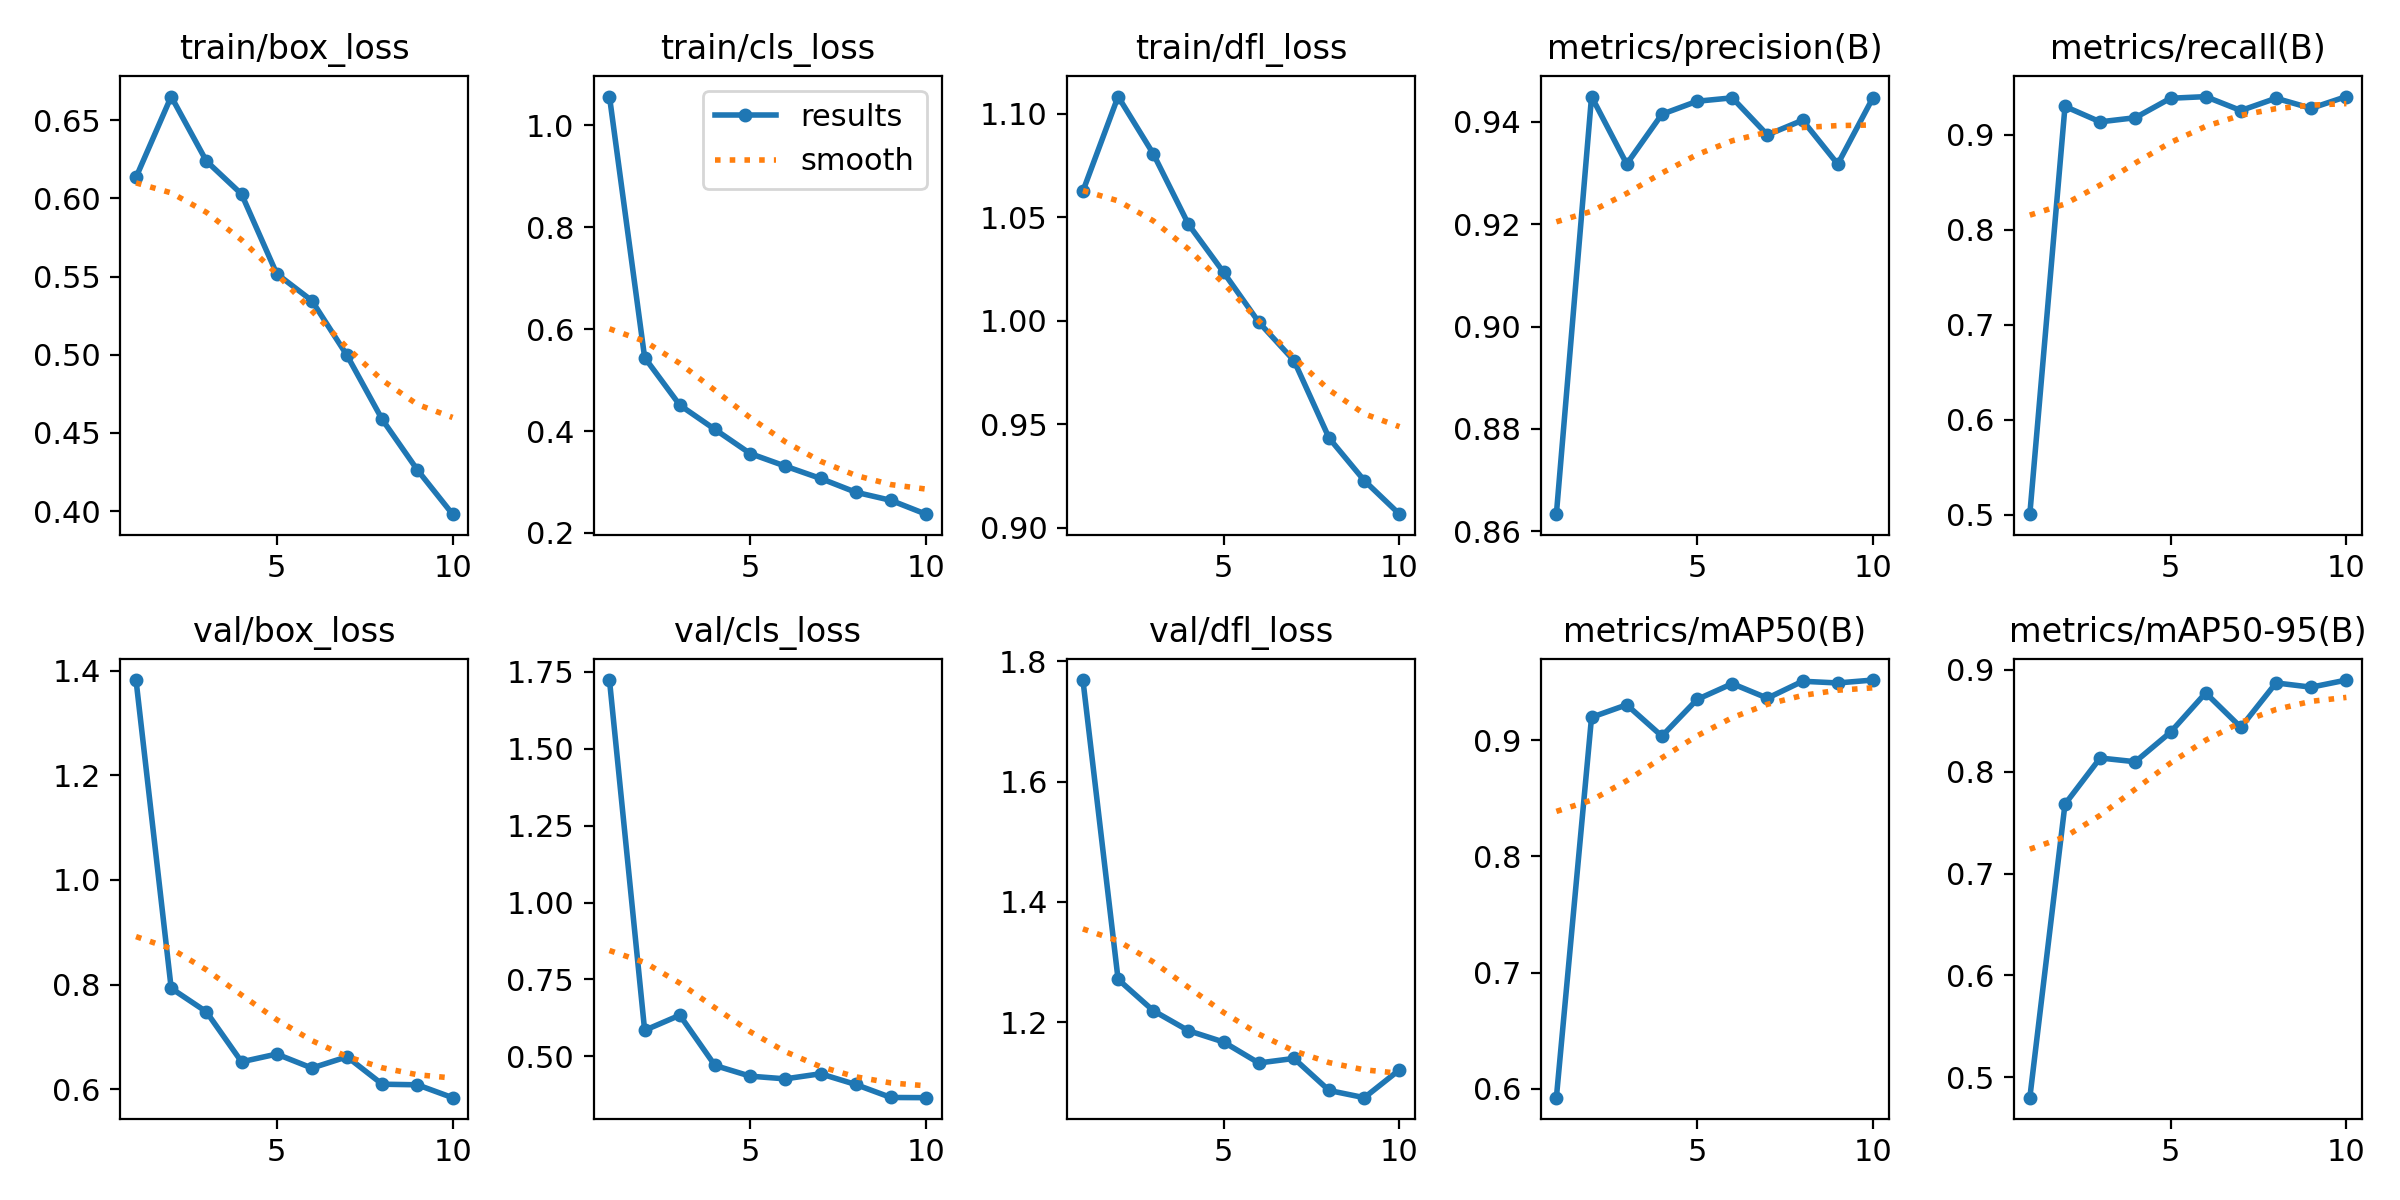

confusion_matrix.png:


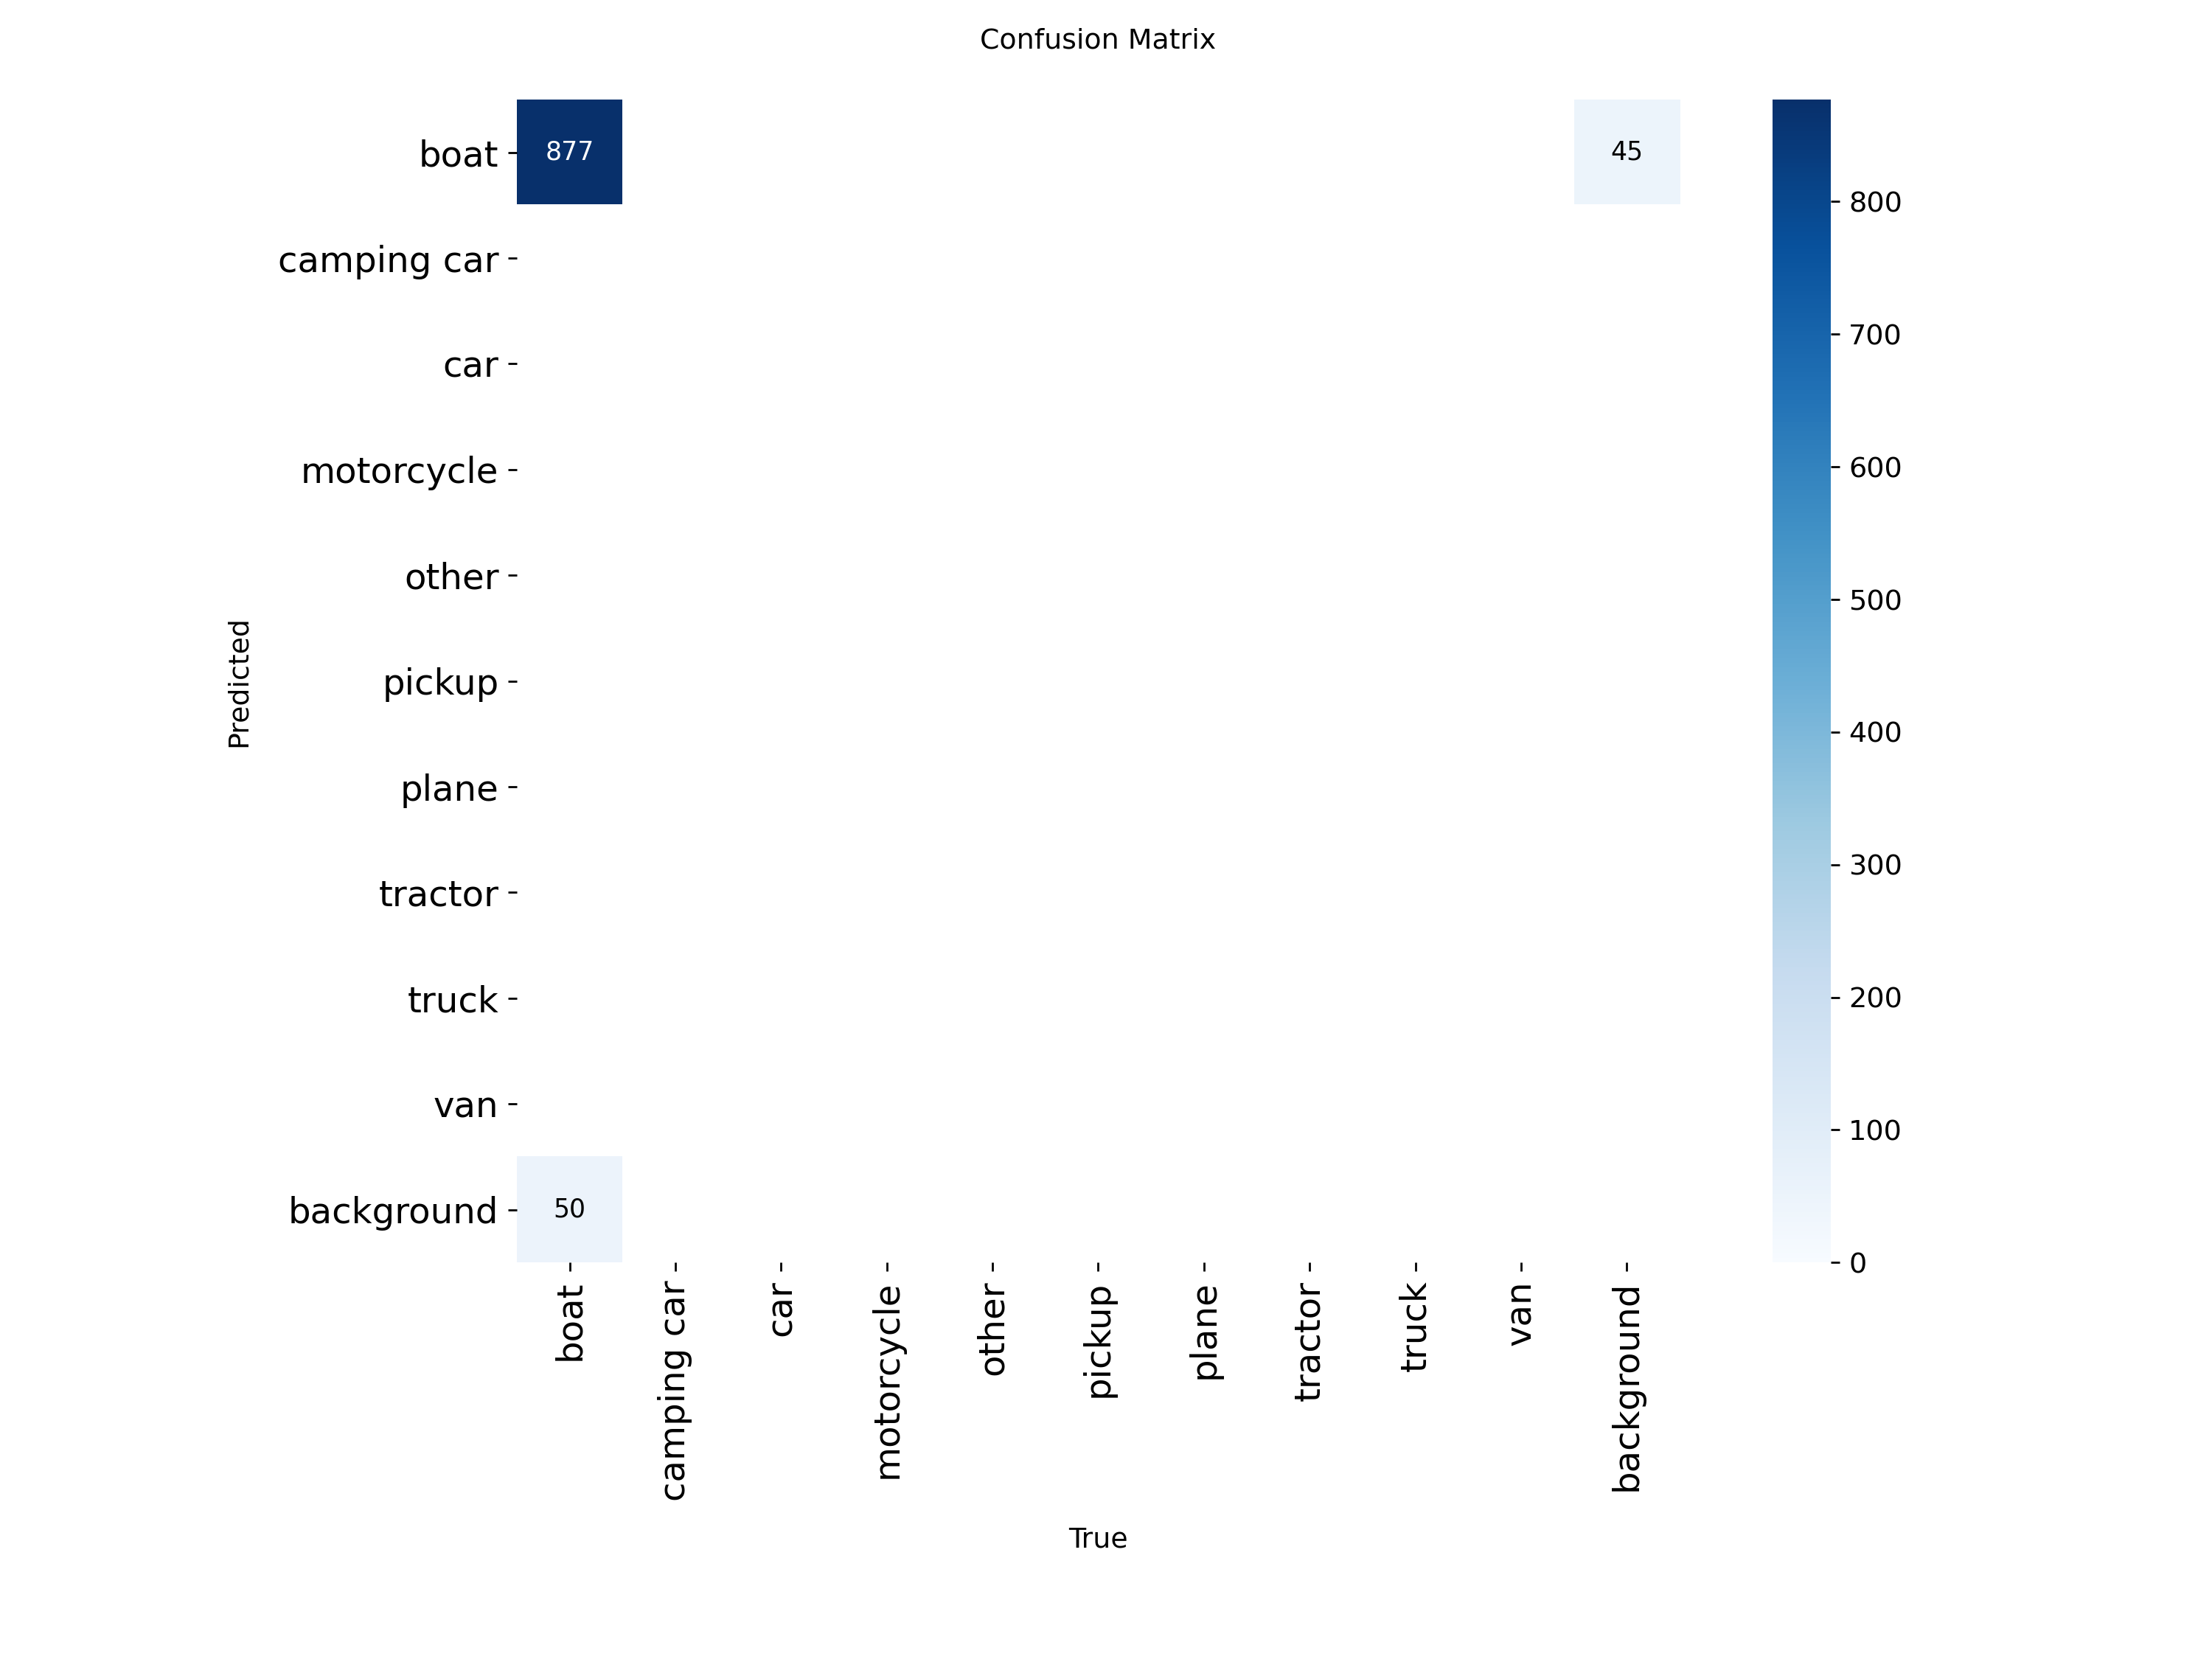

In [ ]:
from IPython.display import Image, display

TRAIN_DIR = "/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main"

print("results.png:")
display(Image(filename=f"{TRAIN_DIR}/results.png", width=600))

print("confusion_matrix.png:")
display(Image(filename=f"{TRAIN_DIR}/confusion_matrix.png", width=600))


val_batch0_pred.jpg:


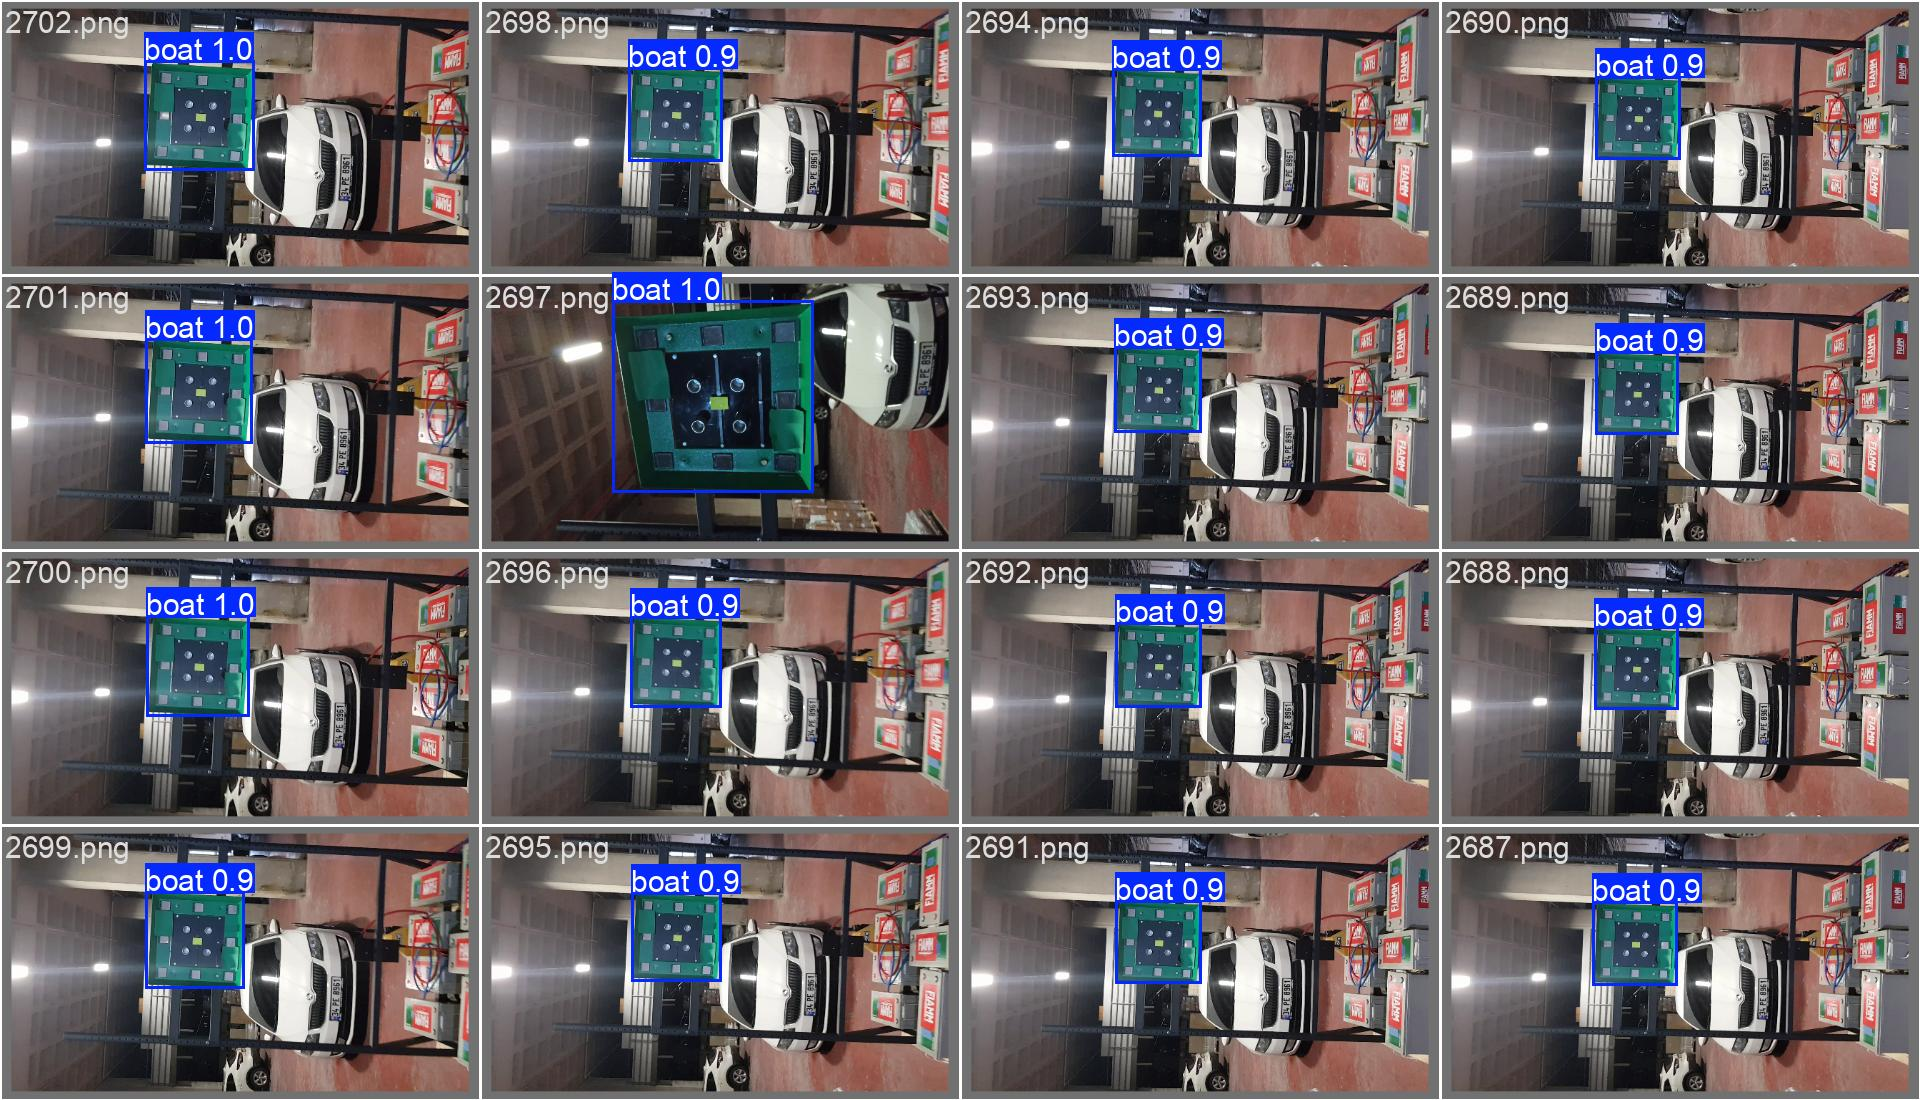

val_batch1_pred.jpg:


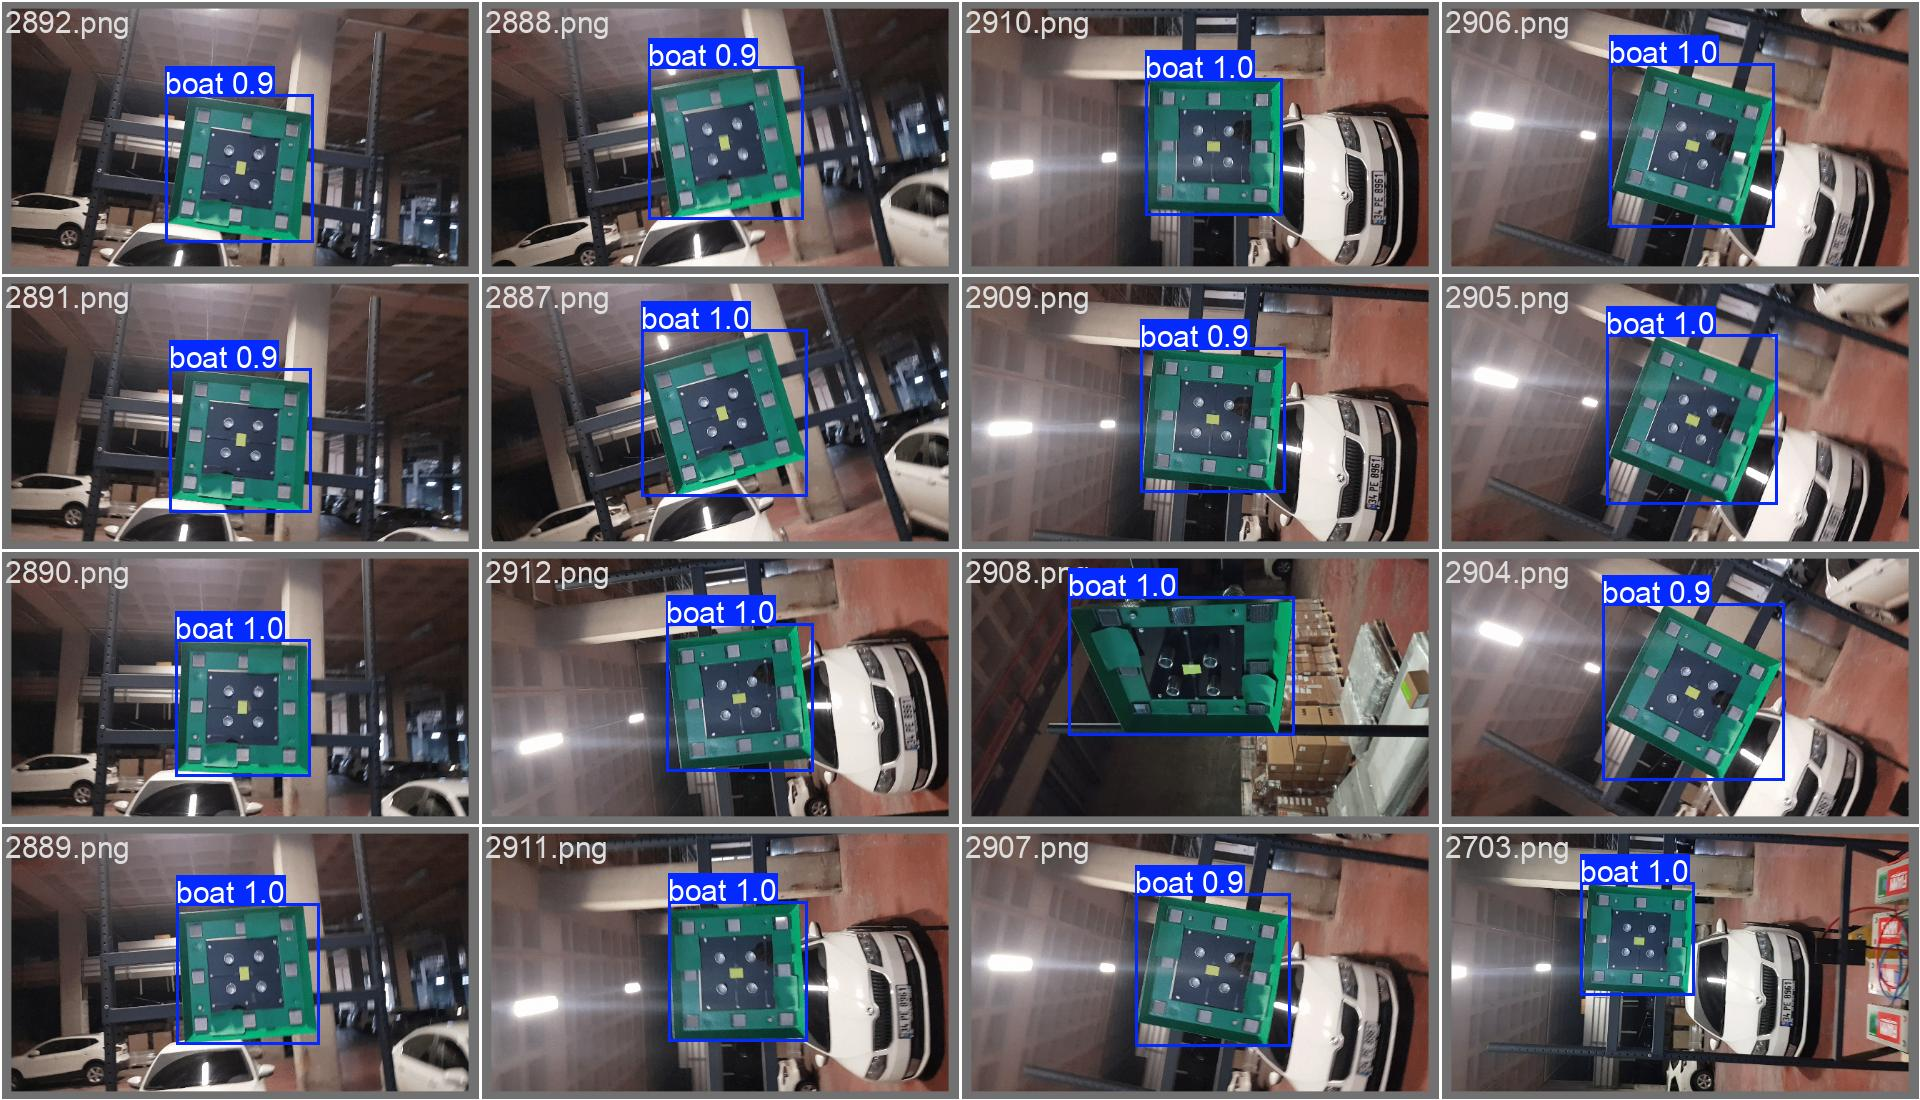

val_batch2_pred.jpg:


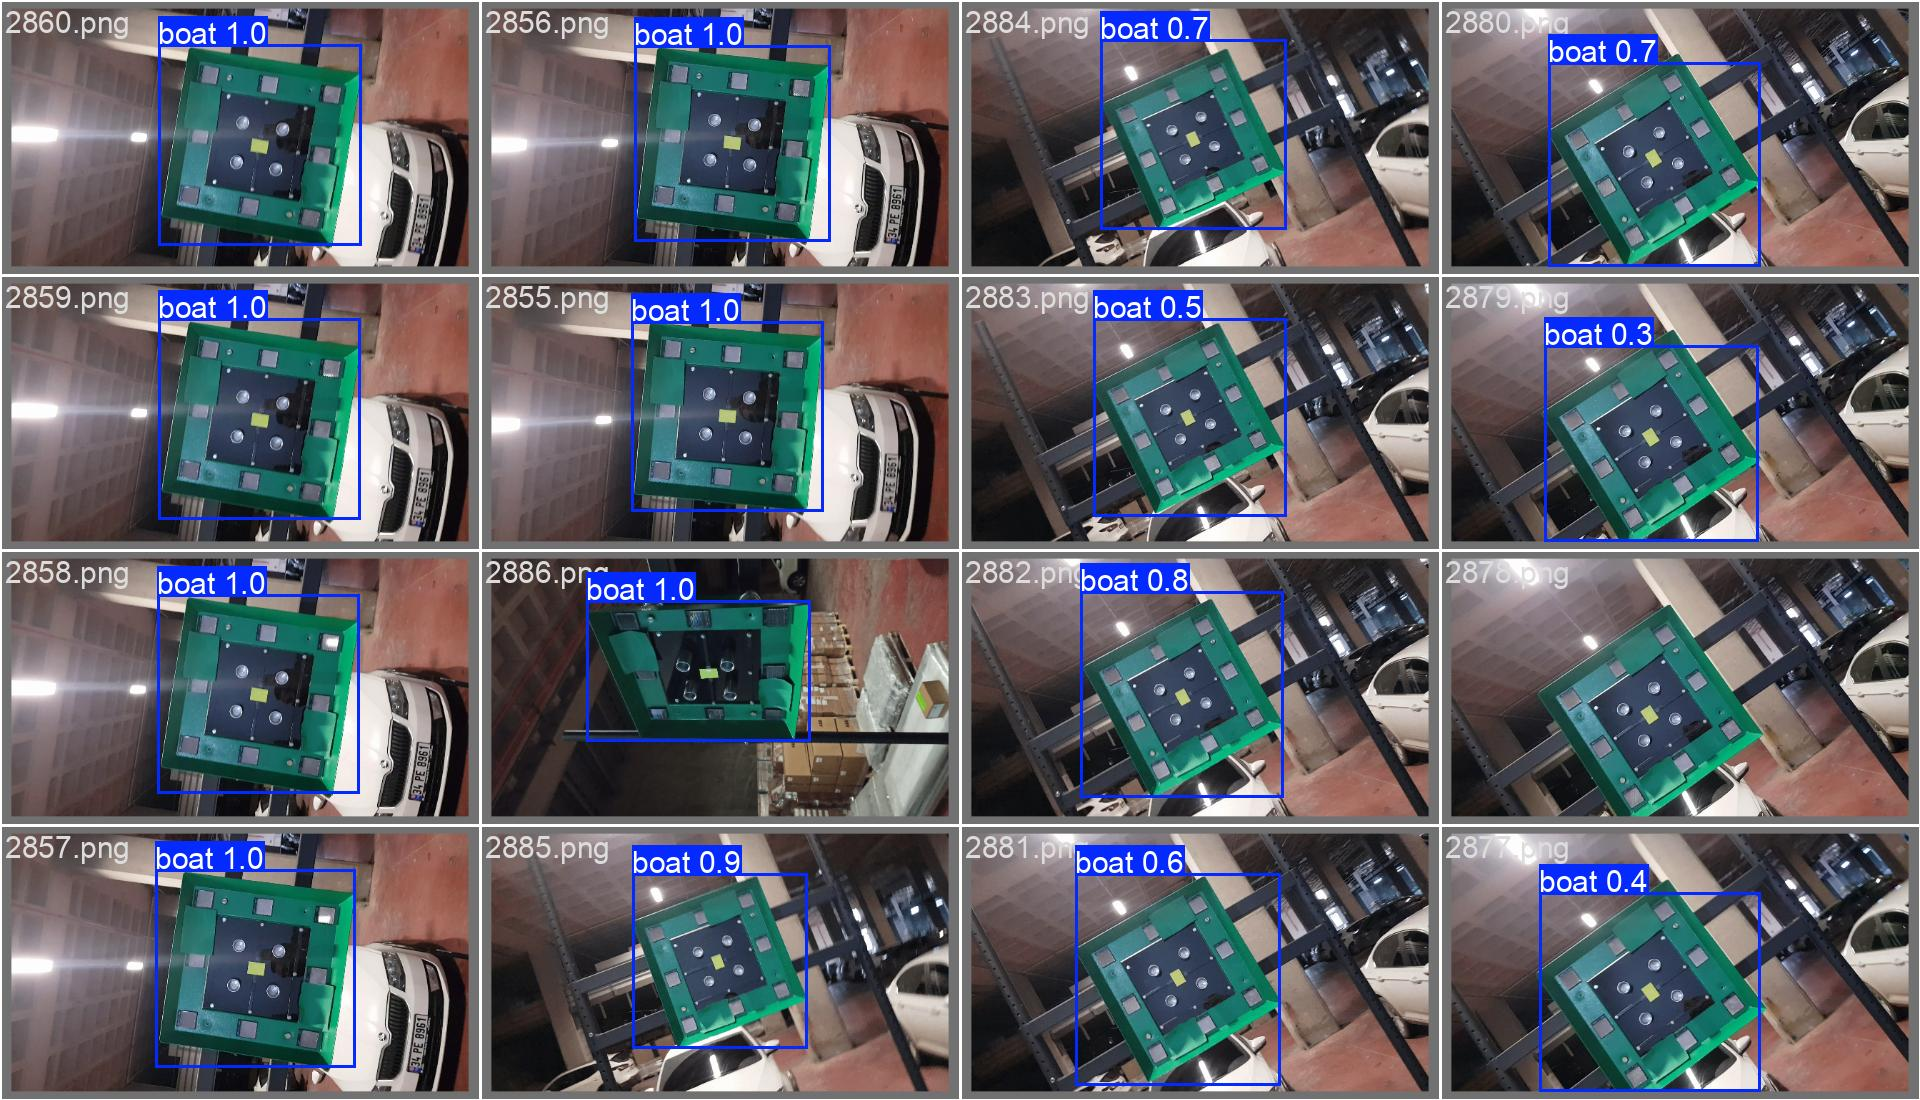

In [ ]:
import os

VAL_PREDS = [
    "val_batch0_pred.jpg",
    "val_batch1_pred.jpg",
    "val_batch2_pred.jpg",
]

for img_name in VAL_PREDS:
    full_path = f"{TRAIN_DIR}/{img_name}"
    if os.path.exists(full_path):
        print(img_name + ":")
        display(Image(filename=full_path, width=600))


train_batch0.jpg:


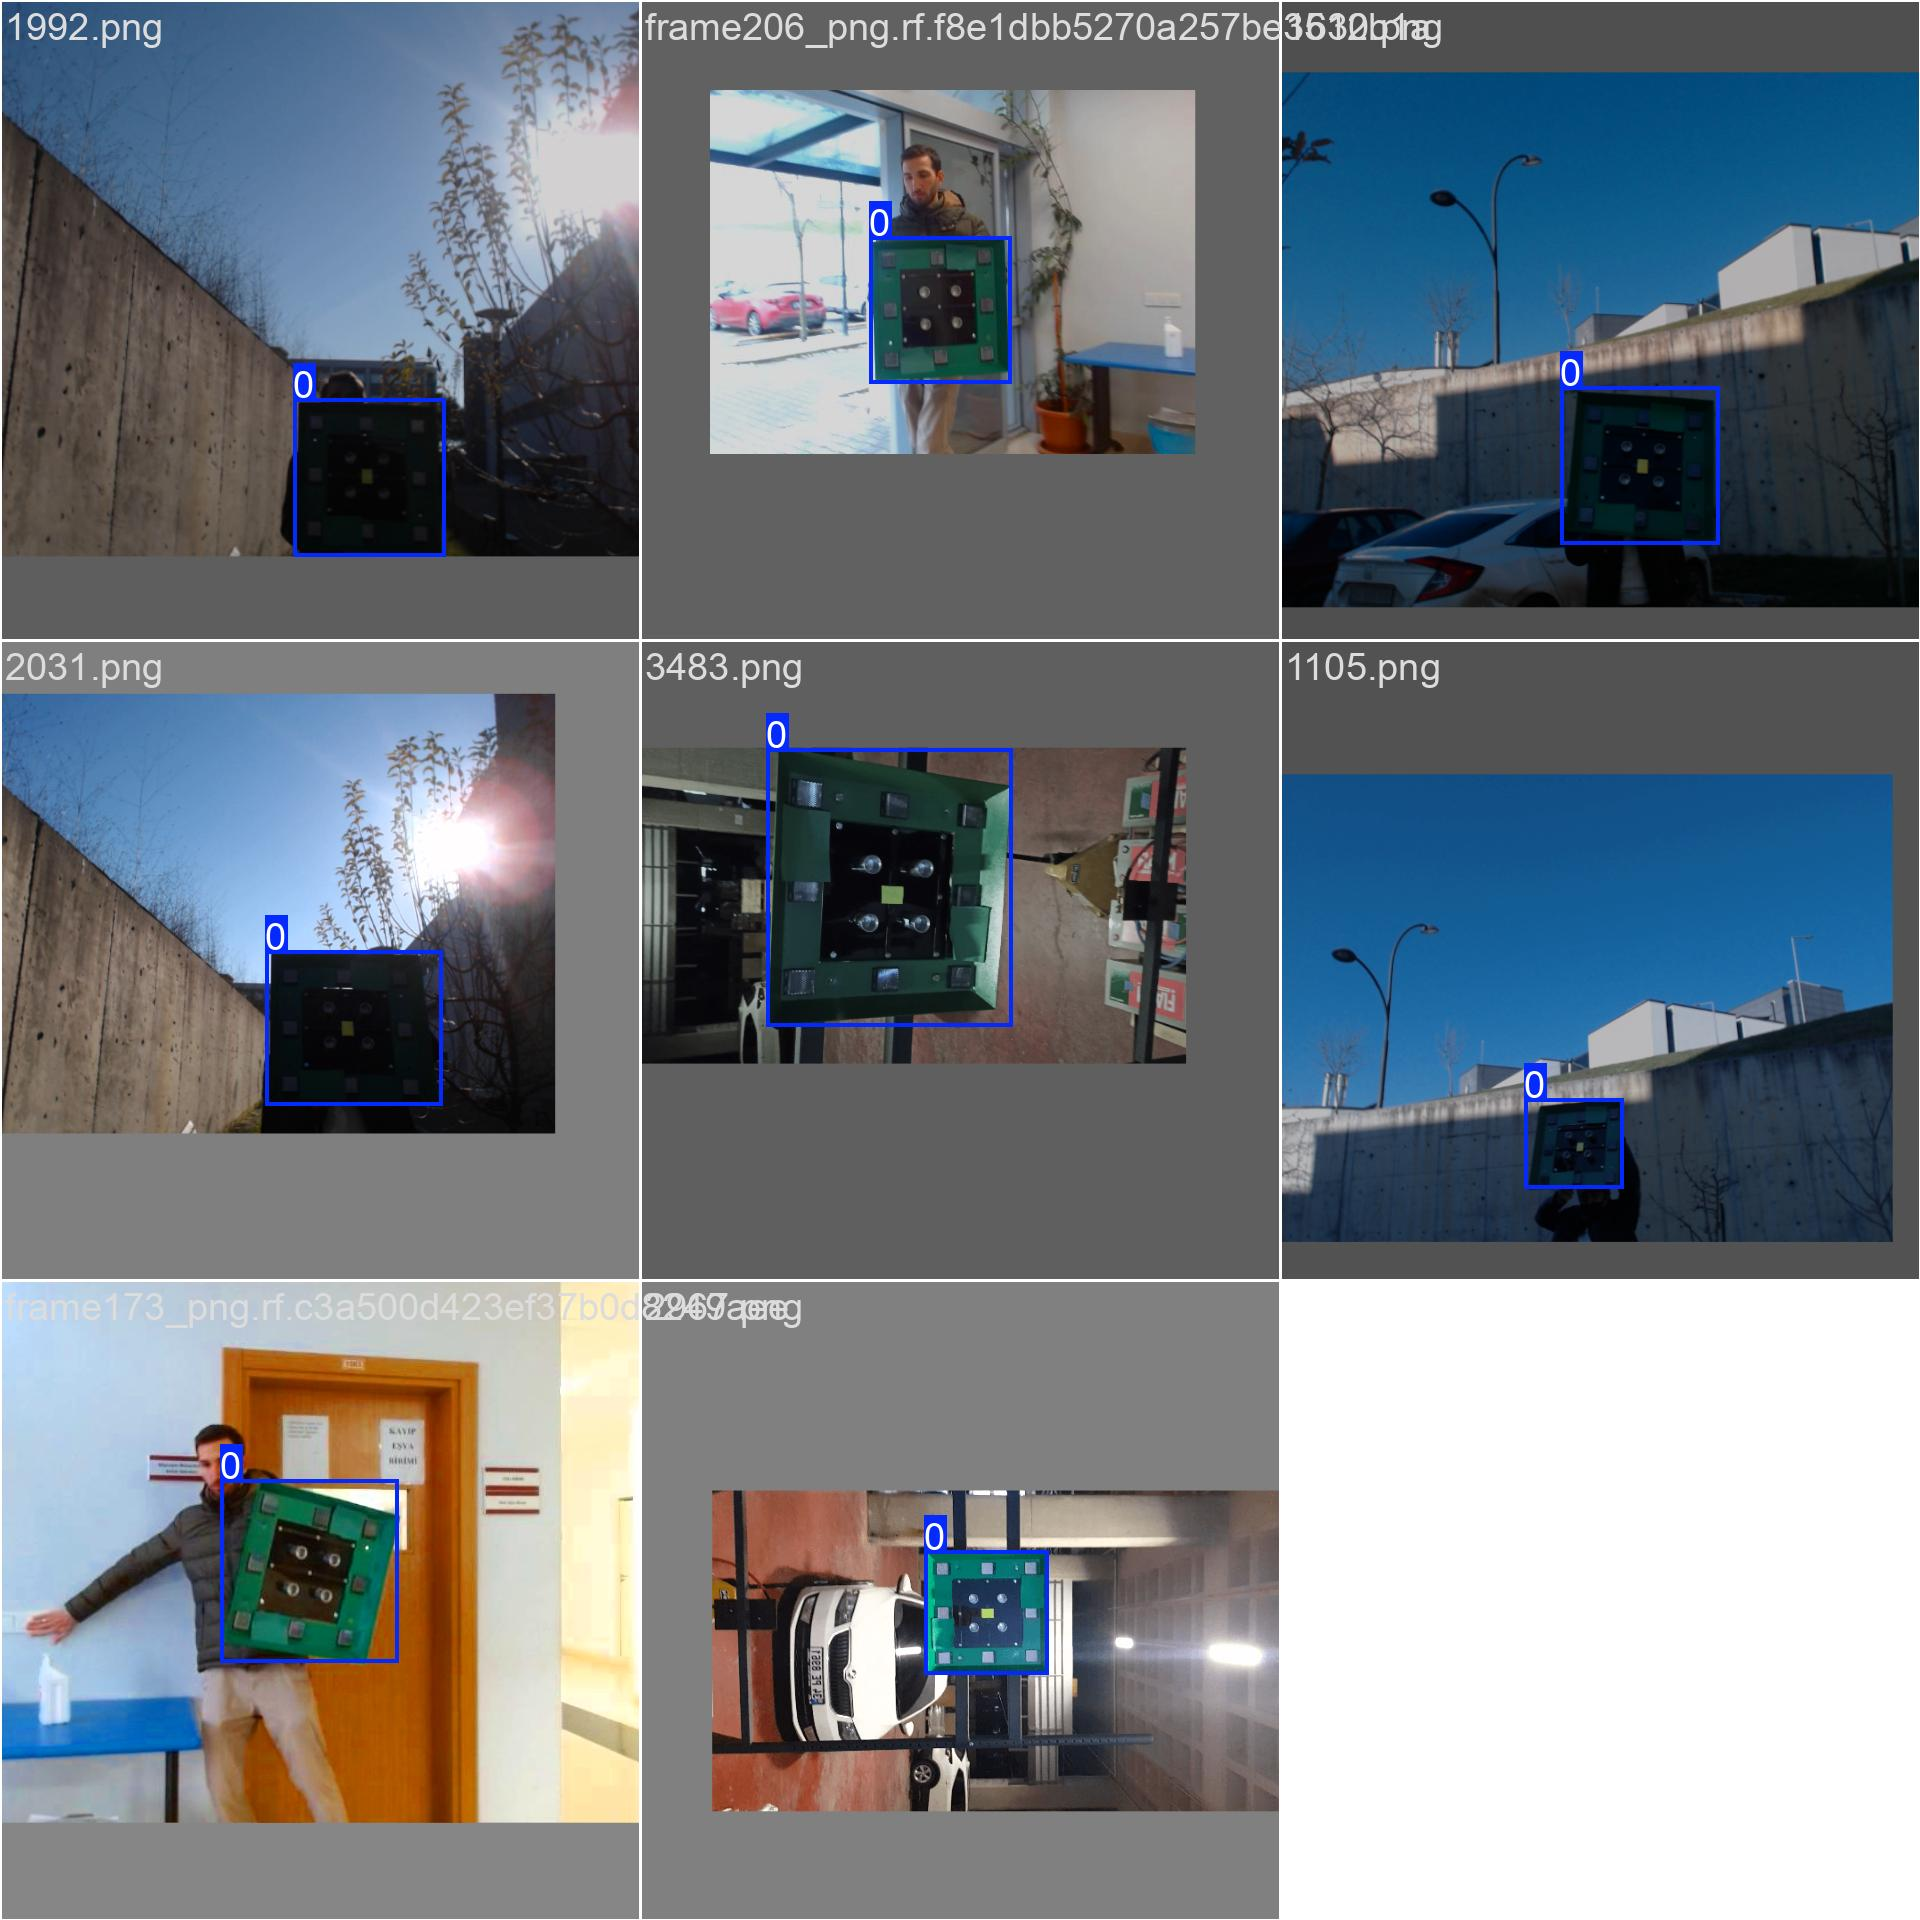

train_batch1.jpg:


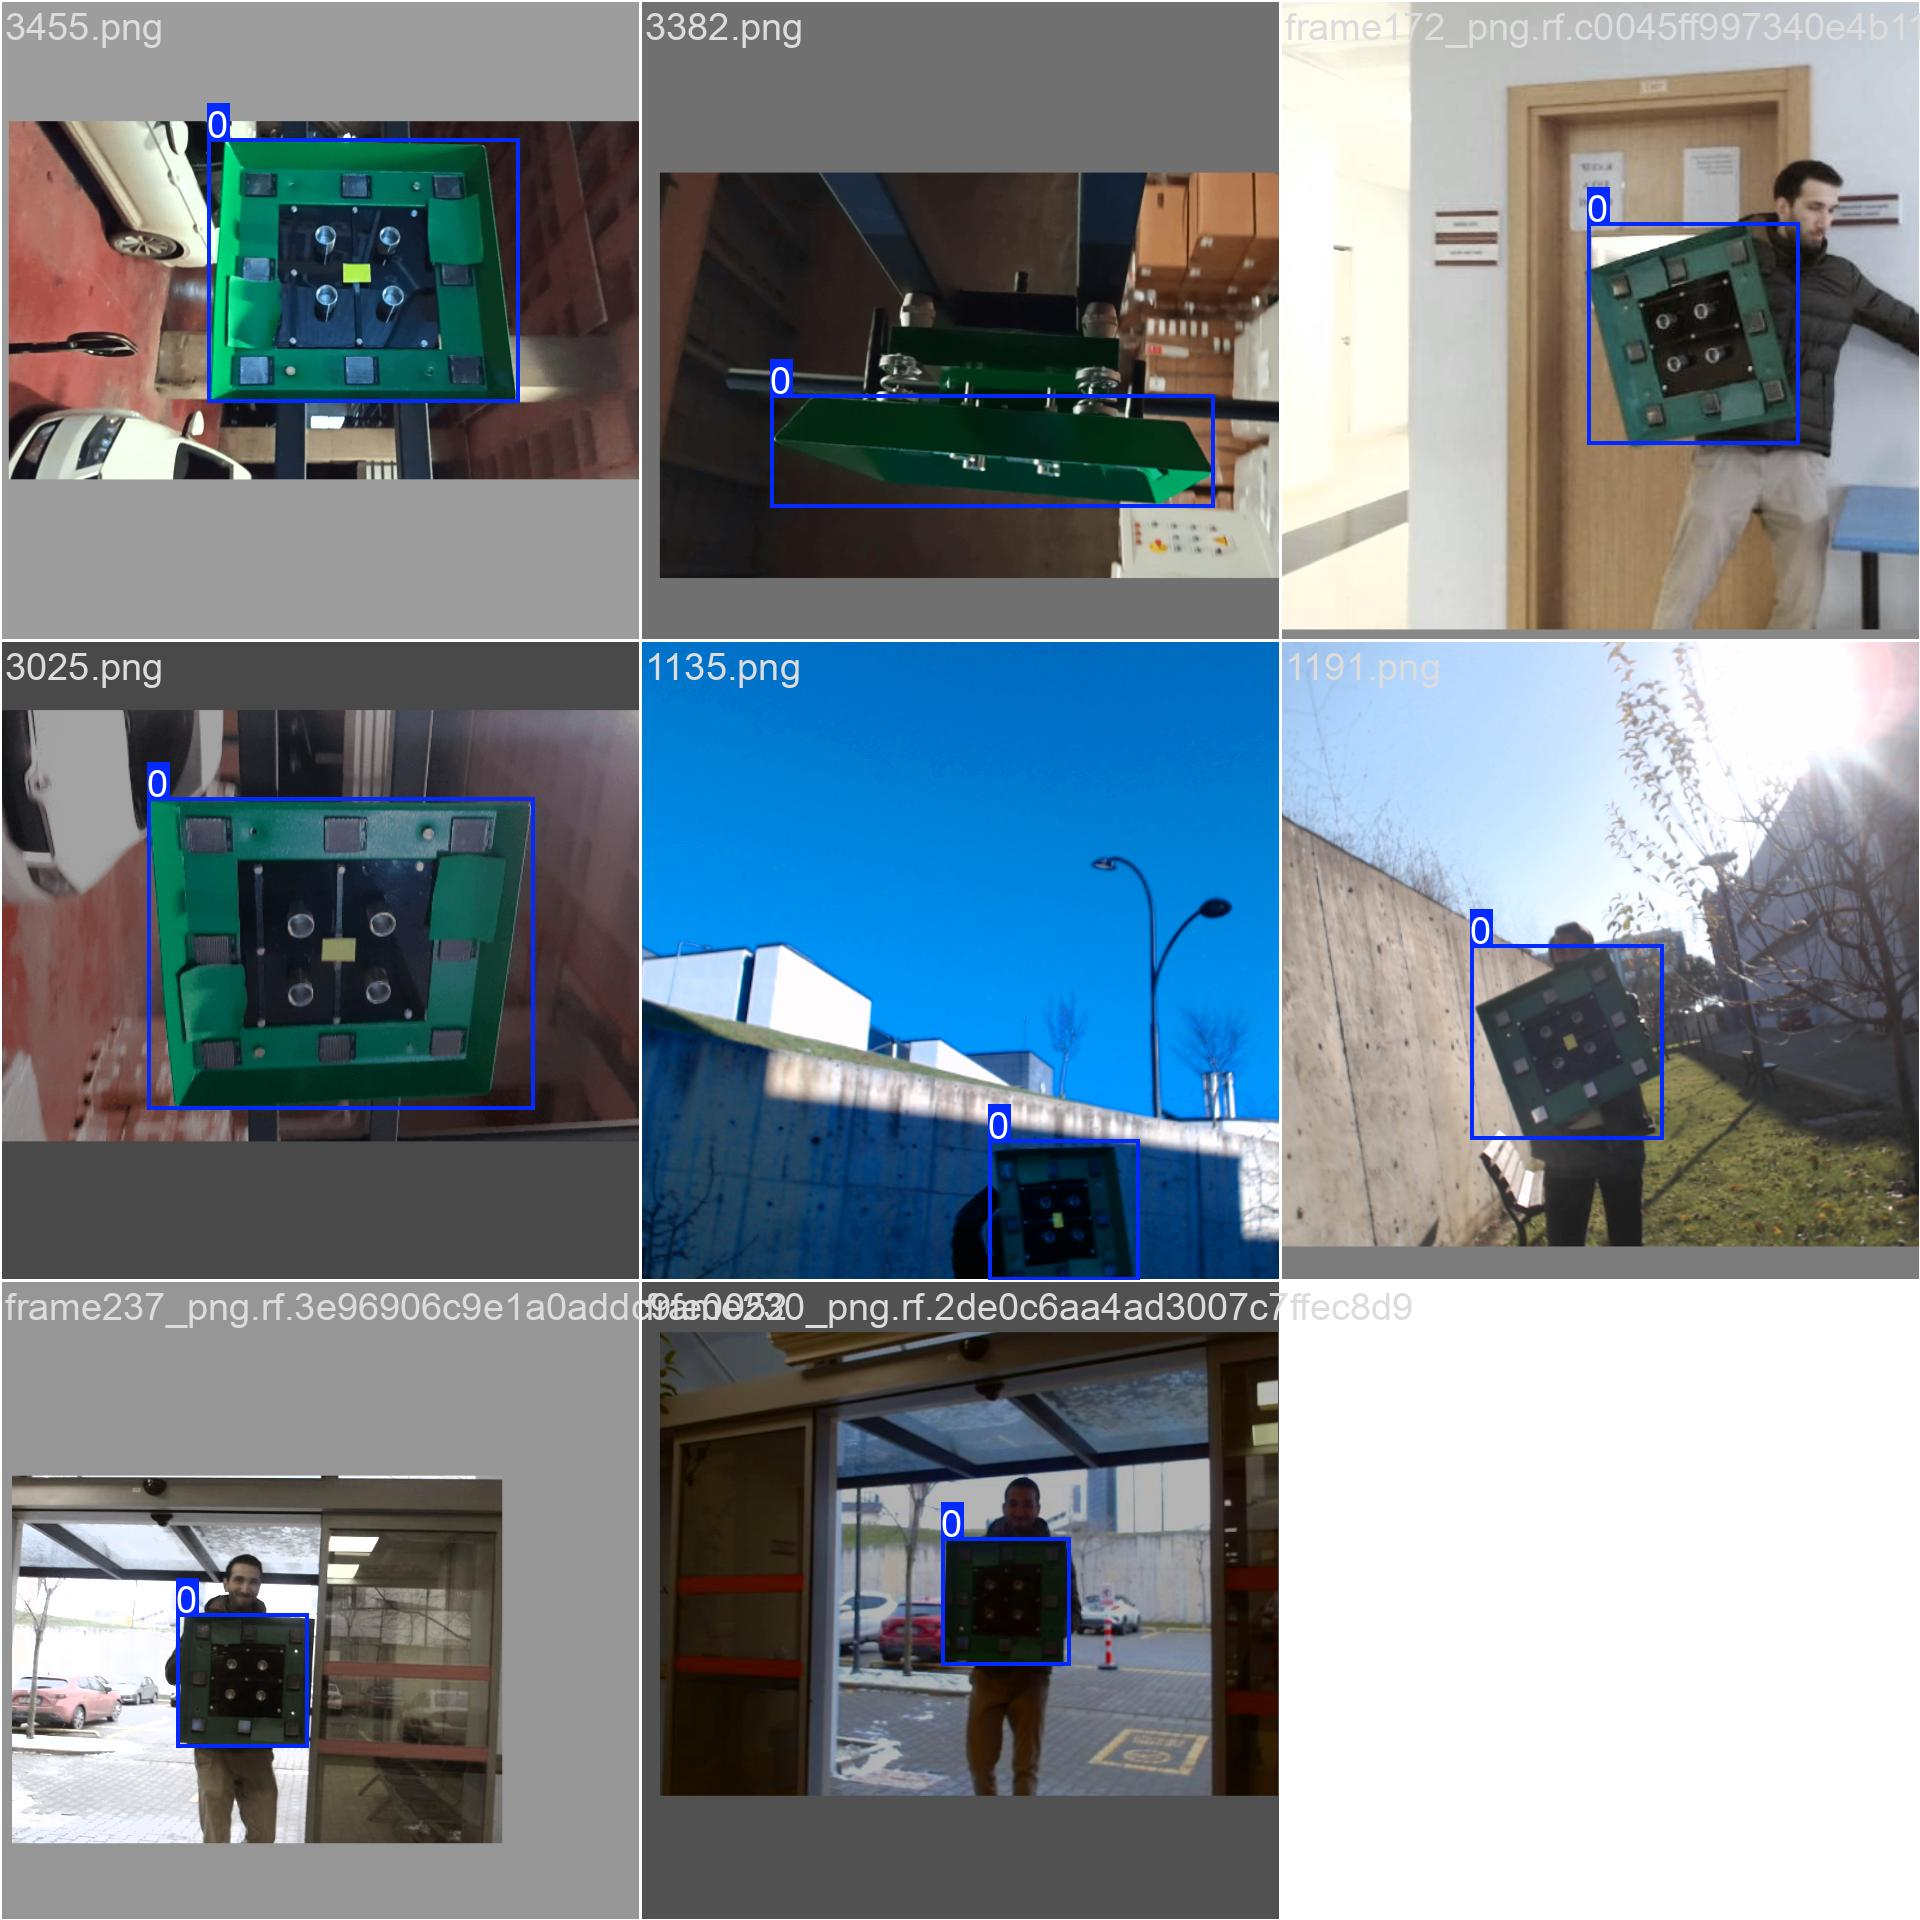

train_batch2.jpg:


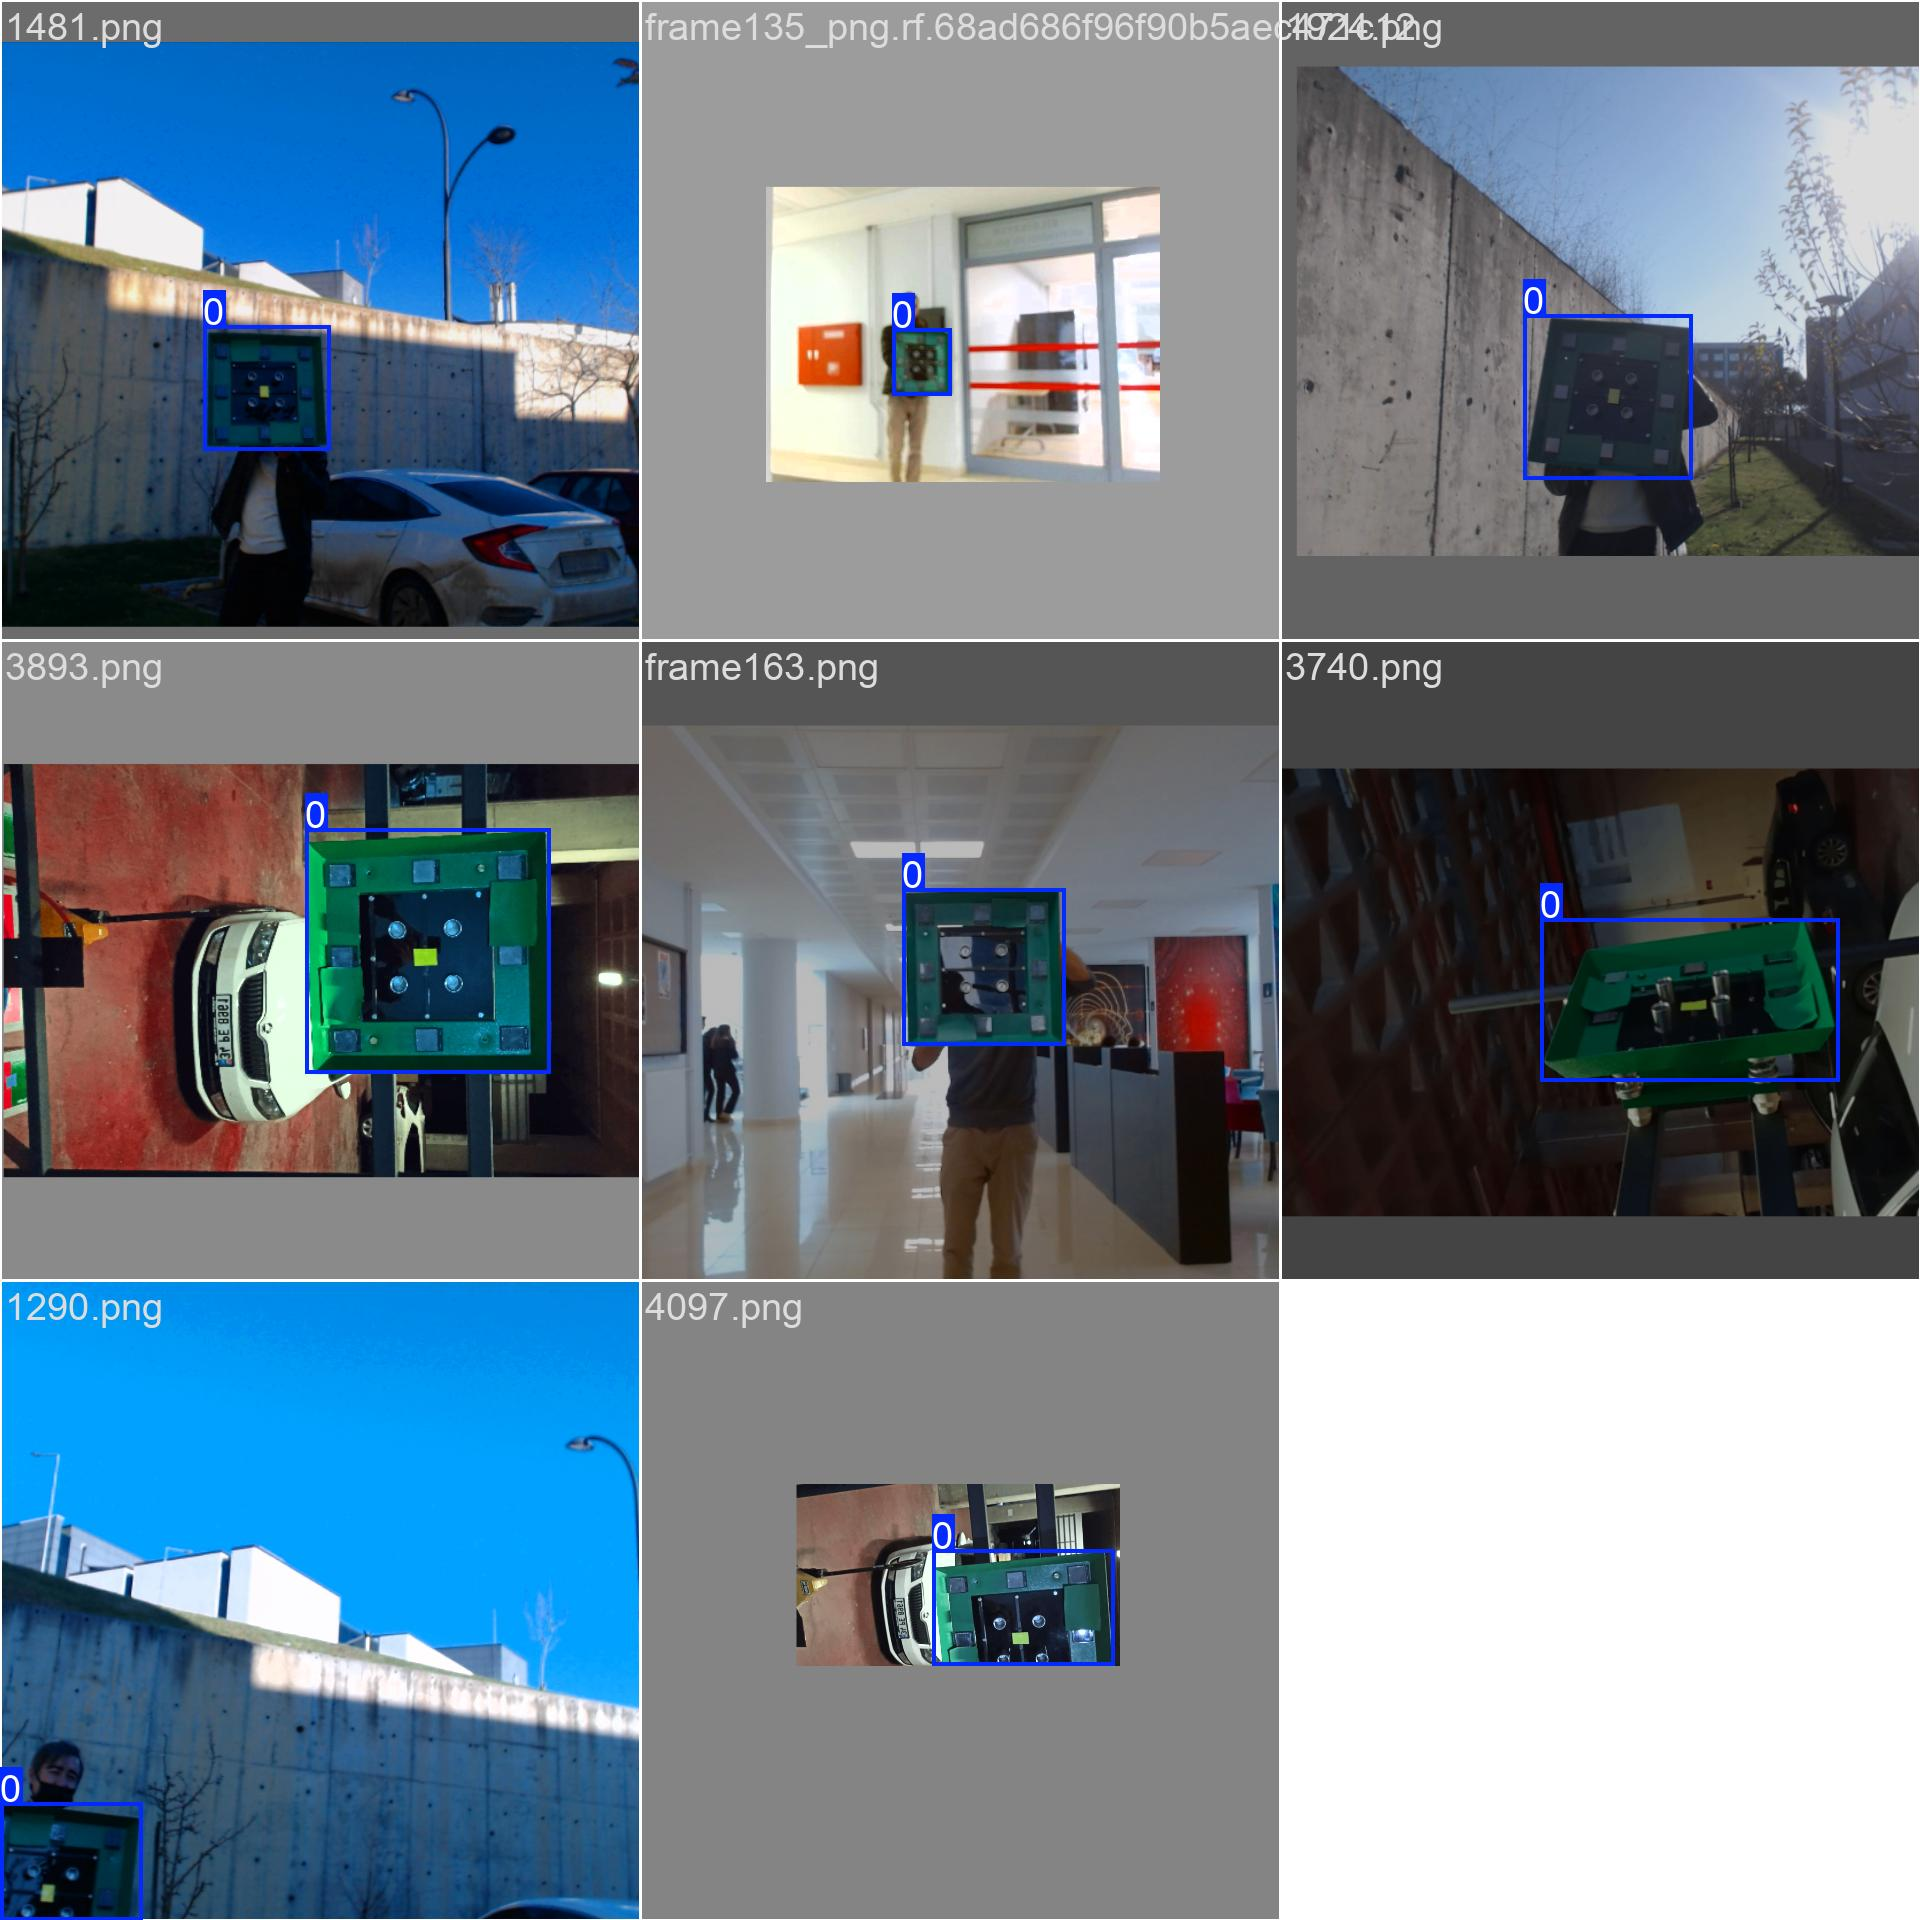

In [ ]:
TRAIN_BATCHES = [
    "train_batch0.jpg",
    "train_batch1.jpg",
    "train_batch2.jpg",
]

for img_name in TRAIN_BATCHES:
    full_path = f"{TRAIN_DIR}/{img_name}"
    if os.path.exists(full_path):
        print(img_name + ":")
        display(Image(filename=full_path, width=600))


In [ ]:
%cd {HOME}

/content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect


In [ ]:
!pwd

/content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect


In [ ]:
# ✅ Correct validation command (Cell 28 fixed)
!yolo task=detect mode=val \
    model=/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main/weights/best.pt \
    data=/content/fixed_data.yaml \
    device=0


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3366.5±597.6 MB/s, size: 1054.4 KB)
val: Scanning /content/train_Gdata/train_Gdata/labels/test.cache... 927 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 927/927 15.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 58/58 1.7it/s 33.3s
                   all        927        927      0.945       0.94      0.952       0.89
                  boat        927        927      0.945       0.94      0.952       0.89
Speed: 1.1ms preprocess, 23.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!gdown "https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t
To: /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4
100% 7.96M/7.96M [00:00<00:00, 19.6MB/s]


In [ ]:
TEST_VIDEO = "/content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4"
OUTPUT_DIR = "/content/video_predictions"

!yolo task=detect mode=predict \
    model=/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main/weights/best.pt \
    source={TEST_VIDEO} \
    imgsz=640 device=0 \
    project={OUTPUT_DIR} \
    name=run1 exist_ok=True


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs

video 1/1 (frame 1/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 59.8ms
video 1/1 (frame 2/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 39.7ms
video 1/1 (frame 3/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 39.7ms
video 1/1 (frame 4/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 32.7ms
video 1/1 (frame 5/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 29.3ms
video 1/1 (frame 6/808) /content/YOLOv8-DeepSORT-Object-Tracking/ultralytics/yolo/v8/detect/test4.mp4: 384x640 (no detections), 29.3ms
video 1/1 (frame 7/808

In [ ]:
from IPython.display import Video, display
import shutil, os, glob

# look for avi or mp4 files
video_candidates = glob.glob("/content/video_predictions/**/*.avi", recursive=True) + \
                   glob.glob("/content/video_predictions/**/*.mp4", recursive=True)
print("Found video files:\n", video_candidates)

if not video_candidates:
    print("⚠️ Still no video found. Run 'ls -R /content/video_predictions' manually to inspect.")
else:
    VIDEO_PATH = video_candidates[0]
    print(f"\n✅ Using: {VIDEO_PATH}")

    # Optional: convert to mp4 for better playback
    OUTPUT_MP4 = "/content/result_converted.mp4"
    !ffmpeg -i "{VIDEO_PATH}" -vcodec libx264 -crf 28 "{OUTPUT_MP4}" -y -loglevel error

    # Display video inside Colab
    display(Video(OUTPUT_MP4, embed=True, width=600))

    # Save a permanent copy to Drive
    DEST_PATH = "/content/drive/MyDrive/yolo_training_alper/final_test4_result.mp4"
    shutil.copy(OUTPUT_MP4, DEST_PATH)
    print(f"\n💾 Copied to Drive: {DEST_PATH}")


Found video files:
 ['/content/video_predictions/run1/test4.avi']

✅ Using: /content/video_predictions/run1/test4.avi



💾 Copied to Drive: /content/drive/MyDrive/yolo_training_alper/final_test4_result.mp4


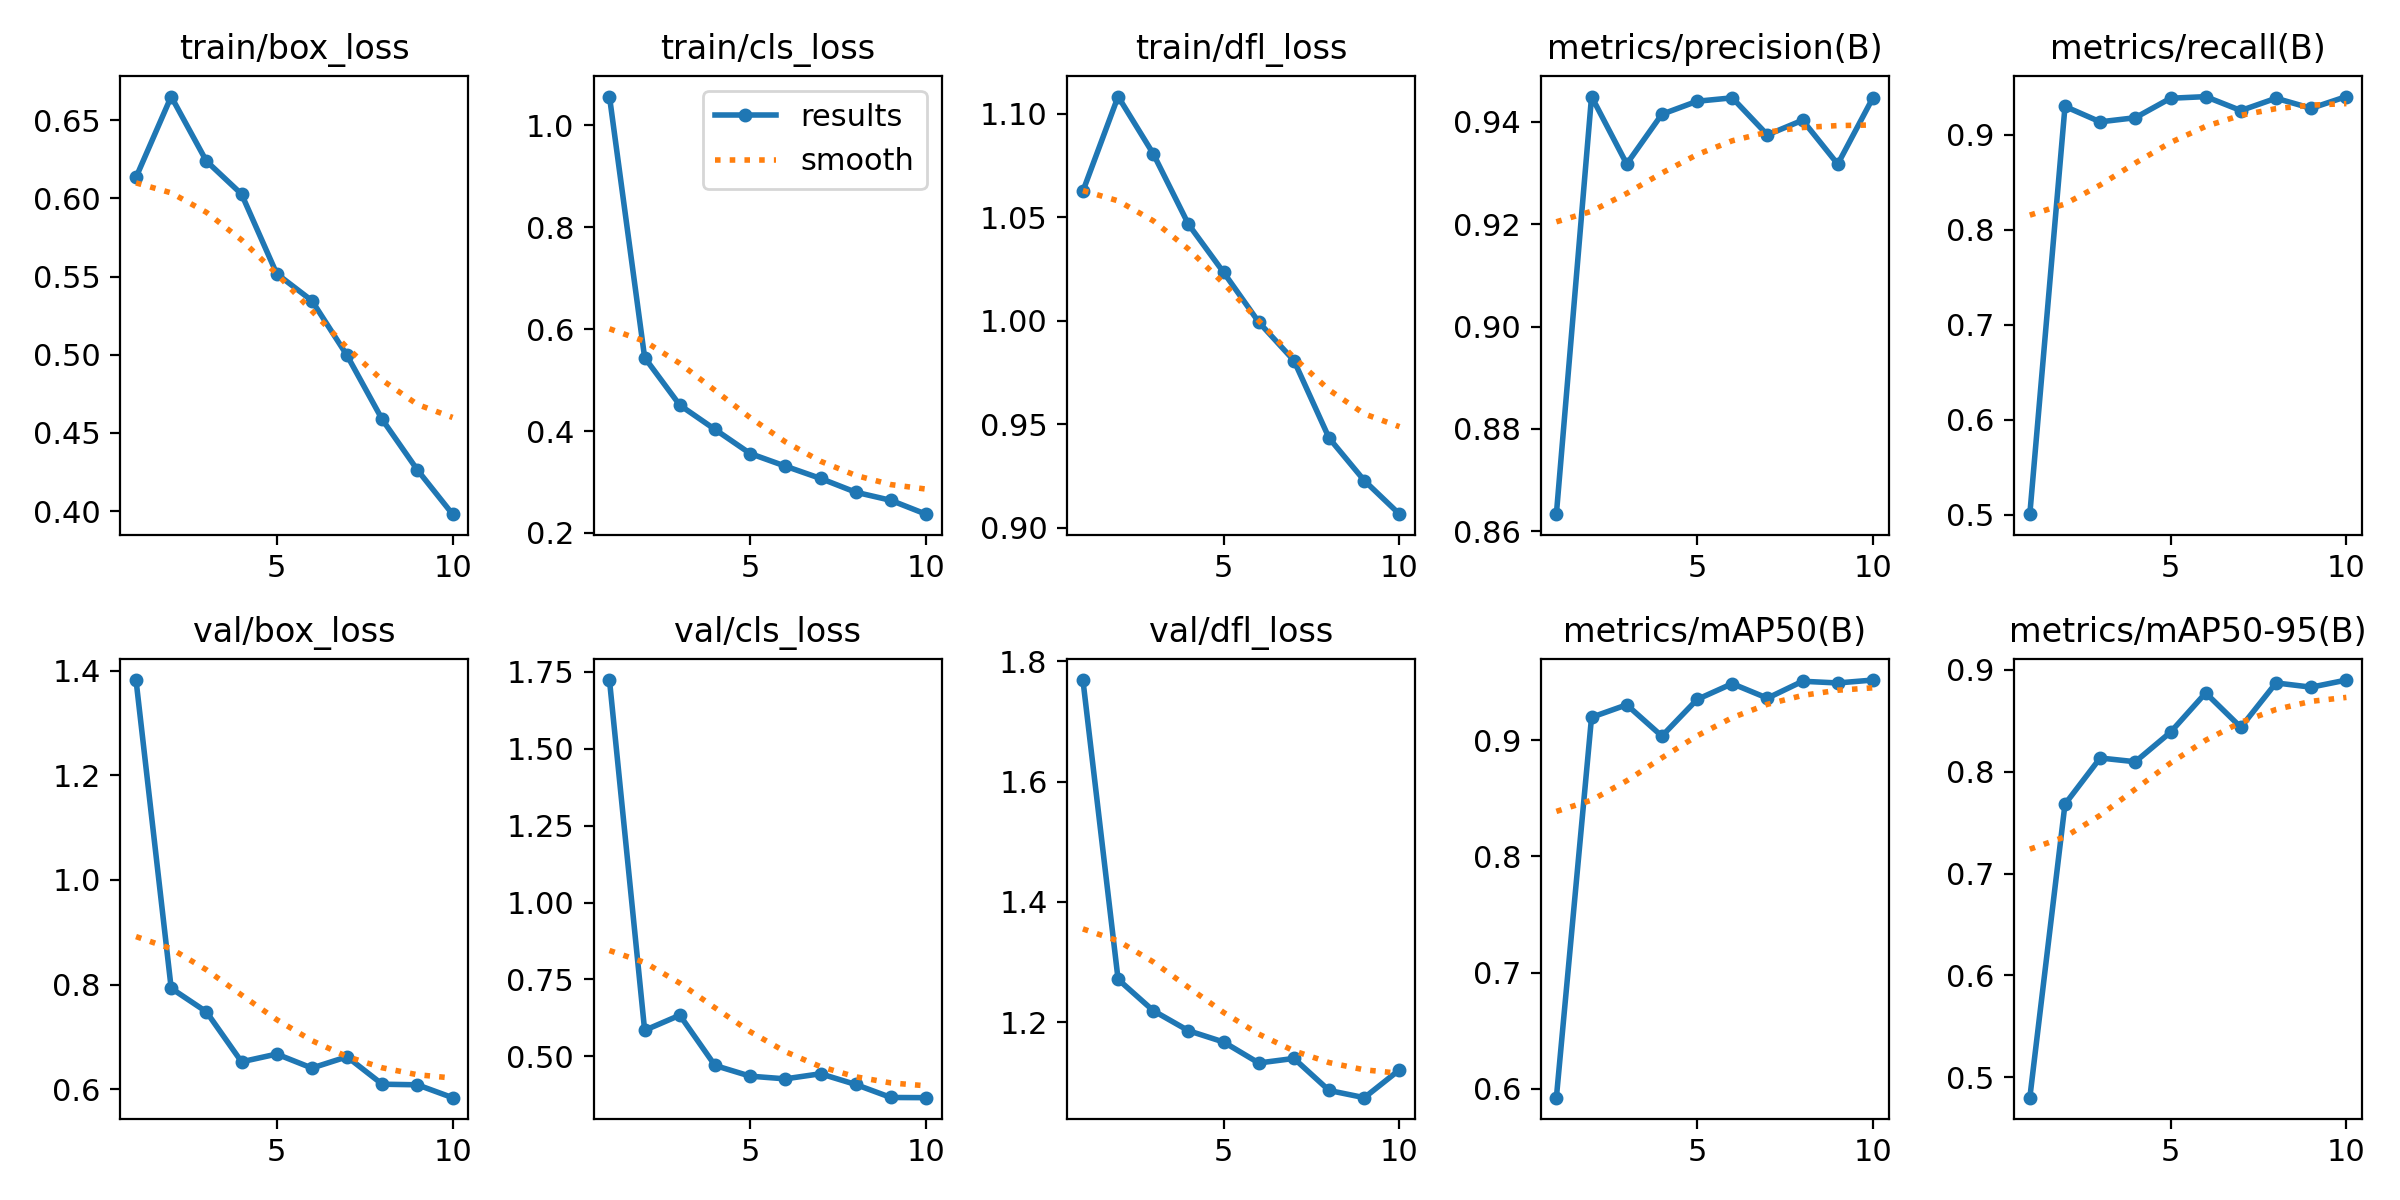

In [ ]:
from IPython.display import Image, display

TRAIN_DIR = "/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main"

display(Image(filename=f"{TRAIN_DIR}/results.png", width=600))


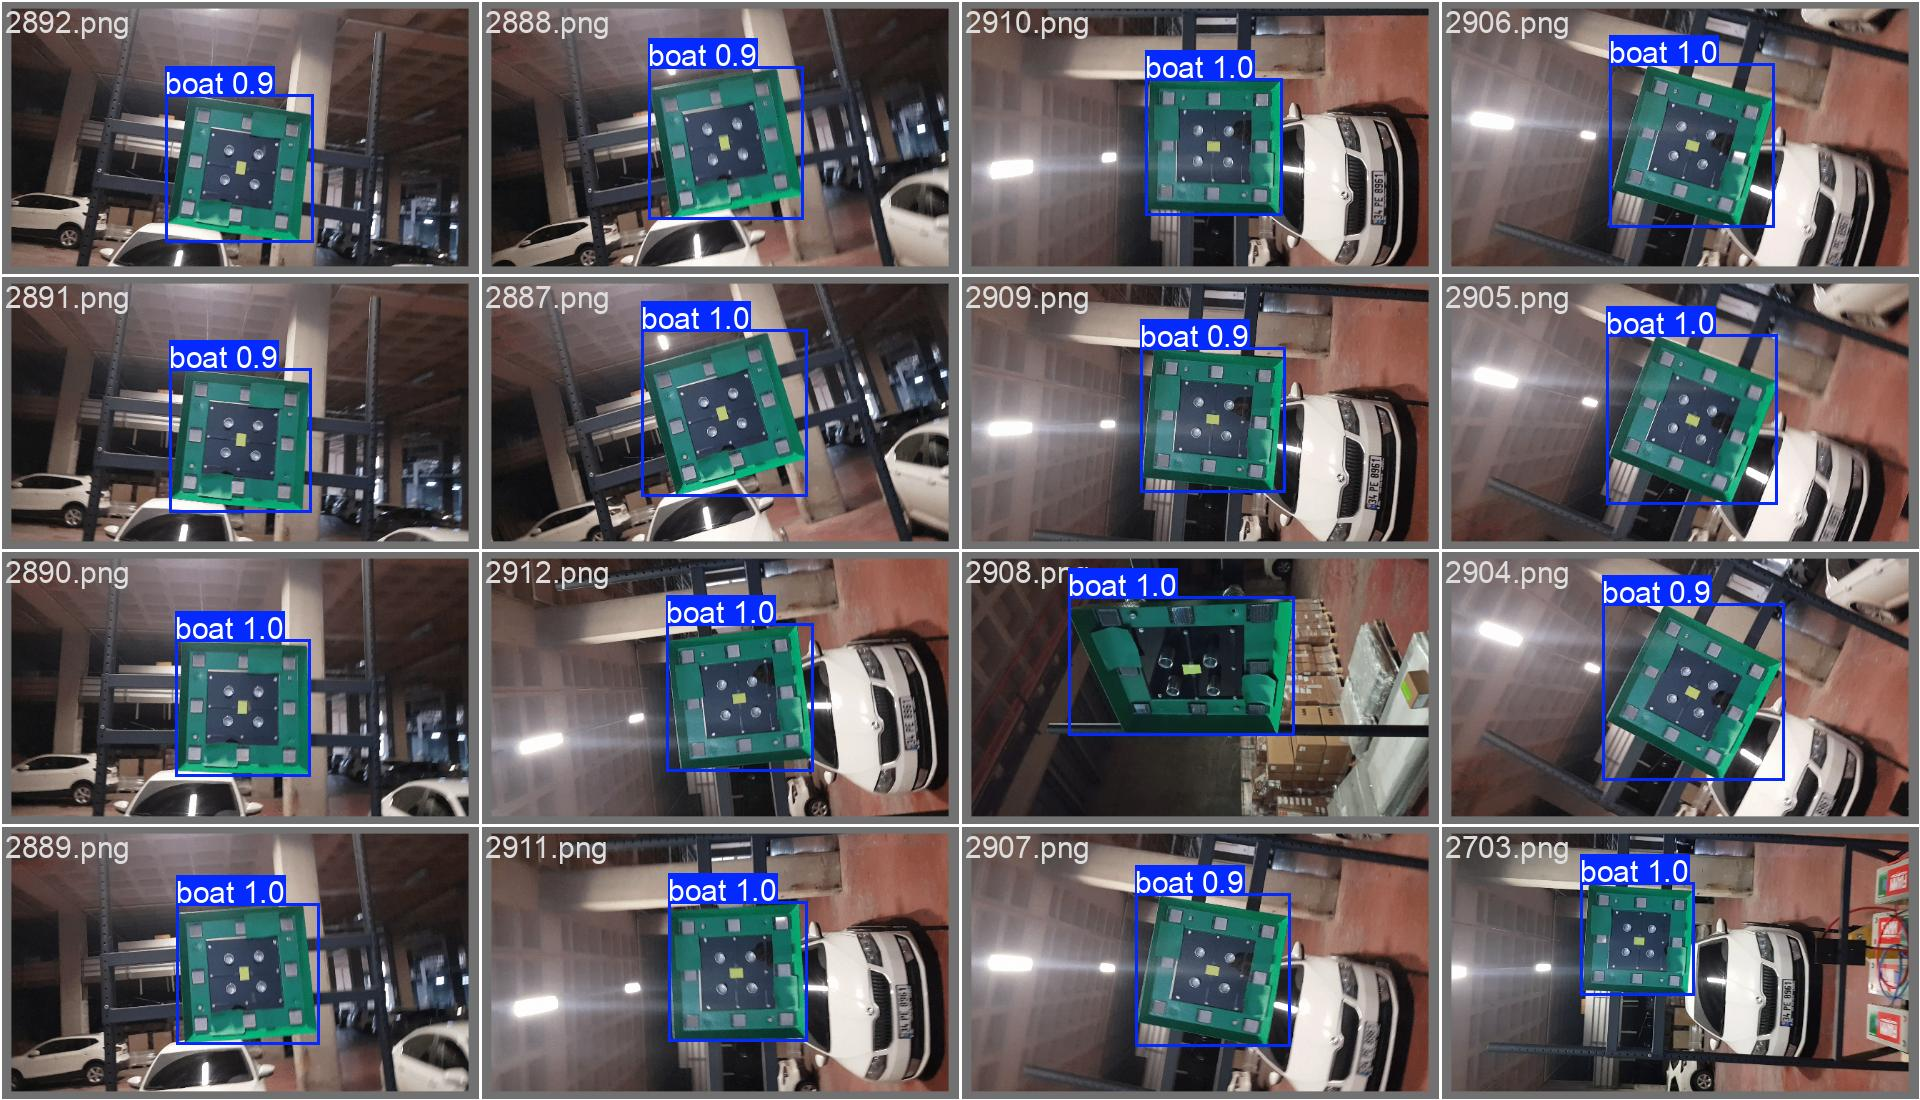

In [ ]:
from IPython.display import Image, display
TRAIN_DIR = "/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main"

display(Image(filename=f"{TRAIN_DIR}/val_batch1_pred.jpg", width=600))


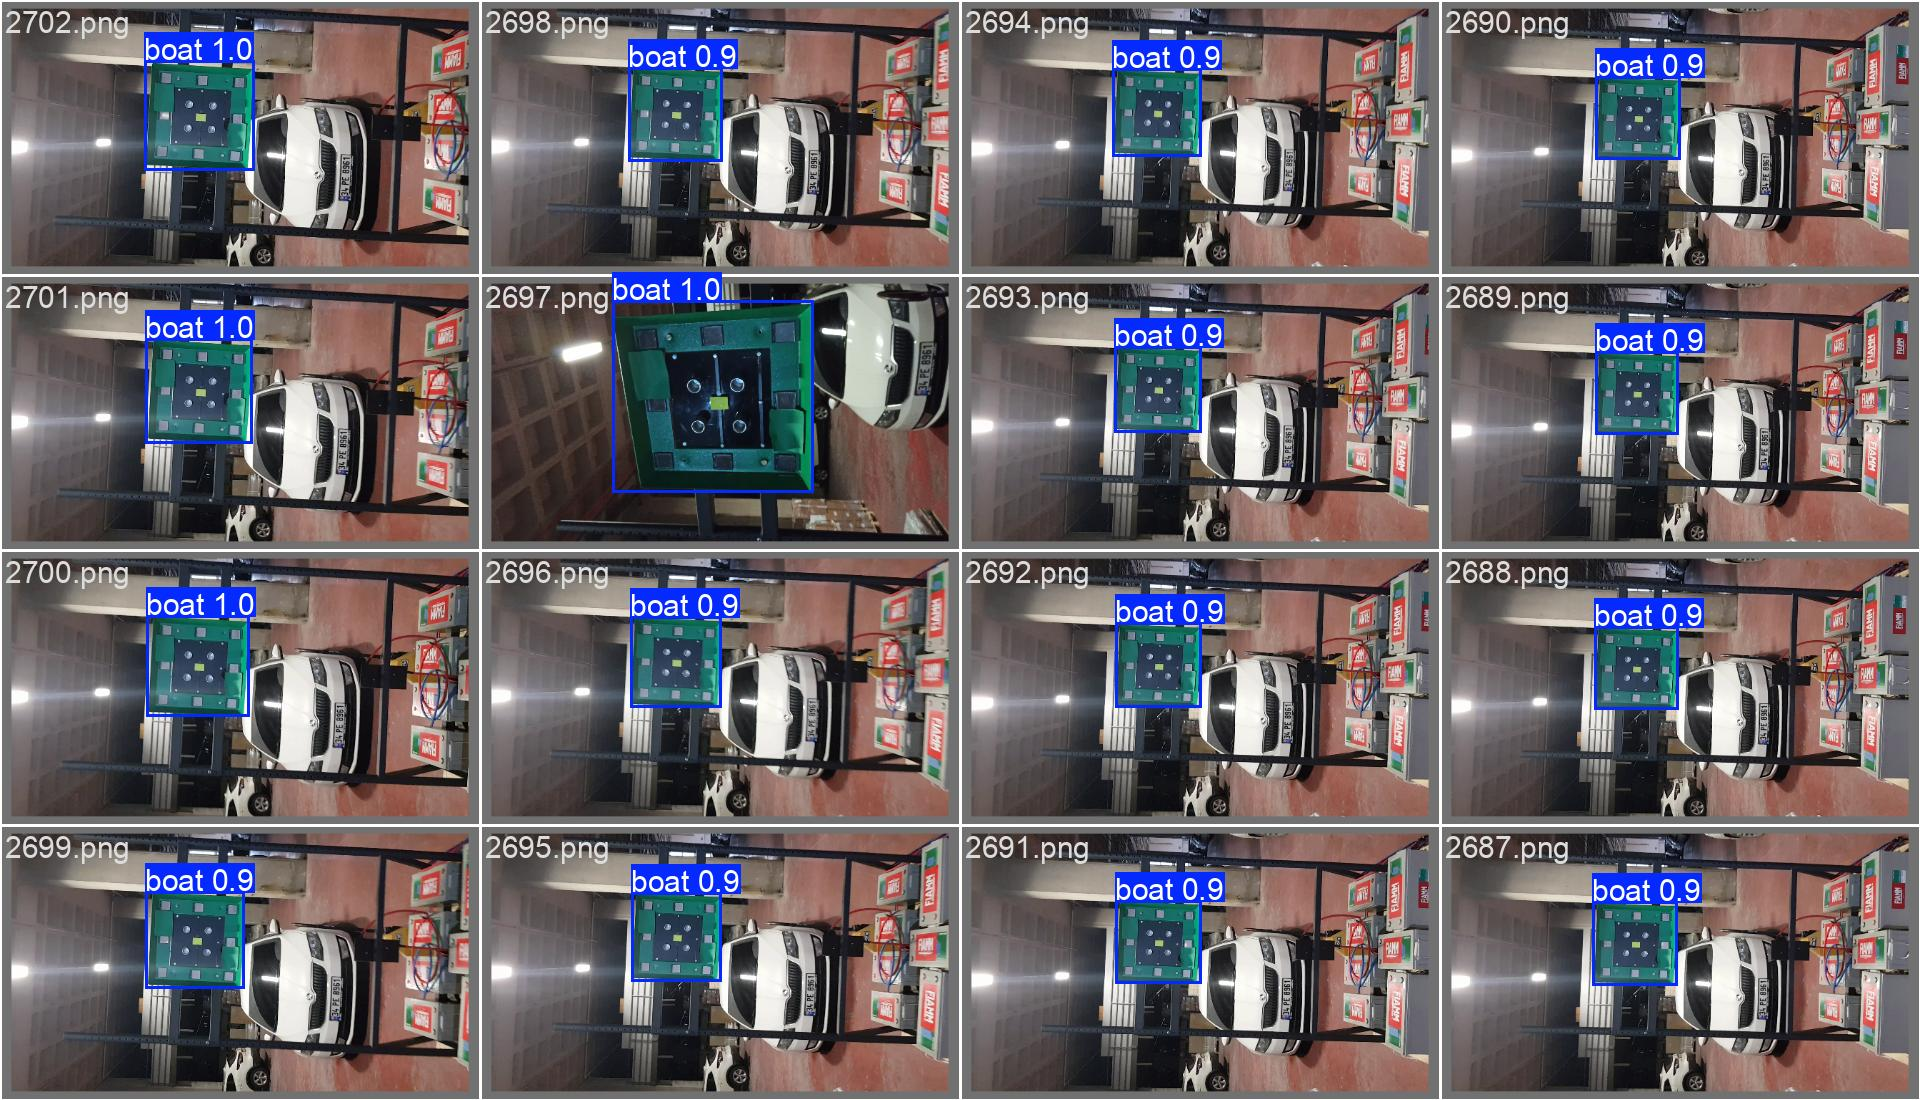

In [ ]:
from IPython.display import Image, display
TRAIN_DIR = "/content/drive/MyDrive/yolo_training_alper/runs/alper_det_main"

display(Image(filename=f"{TRAIN_DIR}/val_batch0_pred.jpg", width=600))
